<a href="https://colab.research.google.com/github/dmamur/elembert/blob/noPosEmbeddings/elembert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    encoder_output = word_embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [2]:
!git clone https://github.com/dmamur/elementsem.git

fatal: destination path 'elementsem' already exists and is not an empty directory.


In [3]:
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembert_'
    MVER = 'V1'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
#'sider_1','sider_2','sider_3','sider_4','sider_5', 'sider_6','sider_7', 'sider_8', 'sider_9', 'sider_10', 'sider_11', 'sider_12',
#'sider_13', 'sider_14', 'sider_15','sider_16','sider_17','sider_18','sider_19','sider_20','sider_21','sider_22','sider_23',
#'sider_24','sider_25','sider_26','sider_27','dimensionality','spacegroup','liquid_amorphous','BBBP','bace','clintox','nr-ahr',
#'nr-ar','sr-atad5','nr-er-lbd','sr-p53','nr-ar-lbd','nr-ppar-gamma','sr-hse','nr-er','sr-mmp','nr-aromatase','sr-are','HIV'
ds = 'toxic_nr-aromatase'
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

# Load vocabulary and types

In [5]:
if (ds=='HIV'):
  df = pd.read_csv(config.DSPATH+ds+config.MVER+'_ds.csv')
else:
  df = pd.read_csv(config.DSPATH+ds+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


vocabSize:  565


# Convert types to integers

In [6]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/elembert_%s_E_%s_H_%s_L_%s.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input(shape=(config.MAX_LEN,), dtype=tf.int32,name='types')
z = create_elembert_model(inputC,config)

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ types (InputLayer)        │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ element_embdgs            │ (None, 256, 32)        │         18,080 │ types[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 256)            │              0 │ types[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_multiheadatten… │ (None, 256, 32)        │          4,224 │ element_embdgs[0][0],  │
│ (MultiHeadAttention)      │                        │                │ element_embdgs[0][0],  │
│                           │                        │                │ element_embdgs[0][0],  │
│                           │                        │                │ not_equal[0][0],       │
│                           │                        │                │ not_equal[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_dropout     │ (None, 256, 32)        │              0 │ encoder_0_multiheadat… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 32)        │              0 │ element_embdgs[0][0],  │
│                           │                        │                │ encoder_0_att_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_layernorma… │ (None, 256, 32)        │             64 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn             │ (None, 256, 32)        │          2,112 │ encoder_0_att_layerno… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_dropout     │ (None, 256, 32)        │              0 │ encoder_0_ffn[0][0]    │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 32)        │              0 │ encoder_0_att_layerno… │
│                           │                        │                │ encoder_0_ffn_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_layernorma… │ (None, 256, 32)        │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_1_multiheadatten… │ (None, 256, 32)        │          4,224 │ encoder_0_ffn_layerno… │
│ (MultiHeadAttention)      │                        │                │ encoder_0_ffn_layerno… │
│                           │                        │                │ encoder_0_ffn_layerno… │
├──────────────────────

 Total params: 31,074 (121.38 KB)

 Trainable params: 31,074 (121.38 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
epochs=2*config.BATCH_SIZE

print('dataLen: ',x3.shape,labels.shape)

p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:int(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE)

model.save(mname+".h5")

dataLen:  (7226, 256) (7226, 2)
Epoch 1/64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - auc: 0.9548 - loss: 0.2115 - val_auc: 0.9750 - val_loss: 0.1922
Epoch 2/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - auc: 0.9672 - loss: 0.1970 - val_auc: 0.9789 - val_loss: 0.1792
Epoch 3/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9730 - loss: 0.1859 - val_auc: 0.9800 - val_loss: 0.1730
Epoch 4/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.9760 - loss: 0.1794 - val_auc: 0.9809 - val_loss: 0.1704
Epoch 5/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9766 - loss: 0.1777 - val_auc: 0.9817 - val_loss: 0.1668
Epoch 6/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9774 - loss: 0.1764 - val_auc: 0.9824 - val_loss: 0.1668
Epoch 7/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.9773 - loss: 0.1762 - val_auc: 0.9826 - val_loss: 0.1650
Epoch 8/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9785 - loss: 0.1734 - val_auc: 0.9825 - val_loss: 0.1653
Epoch 9/64
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.978

# Save results

In [9]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = validx
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


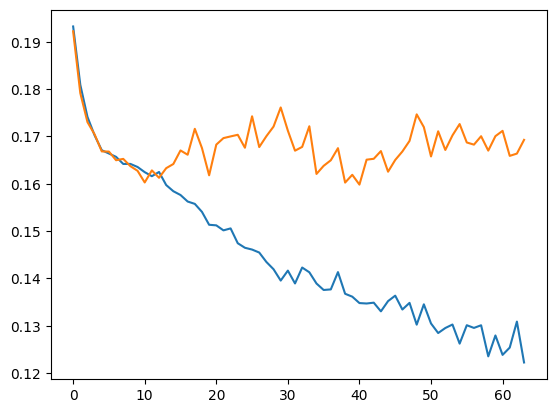

In [10]:
import matplotlib.pyplot as plt
plt.plot(trainlog.history['loss'])
plt.plot(trainlog.history['val_loss'])

# Postprocessing

In [11]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [12]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1)).astype('bool')
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1)).astype('bool')
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

/content/elementsem/models/elembert_toxic_nr-aromatase_V1_E_32_H_2_L_2 binary tf-acc: [1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1

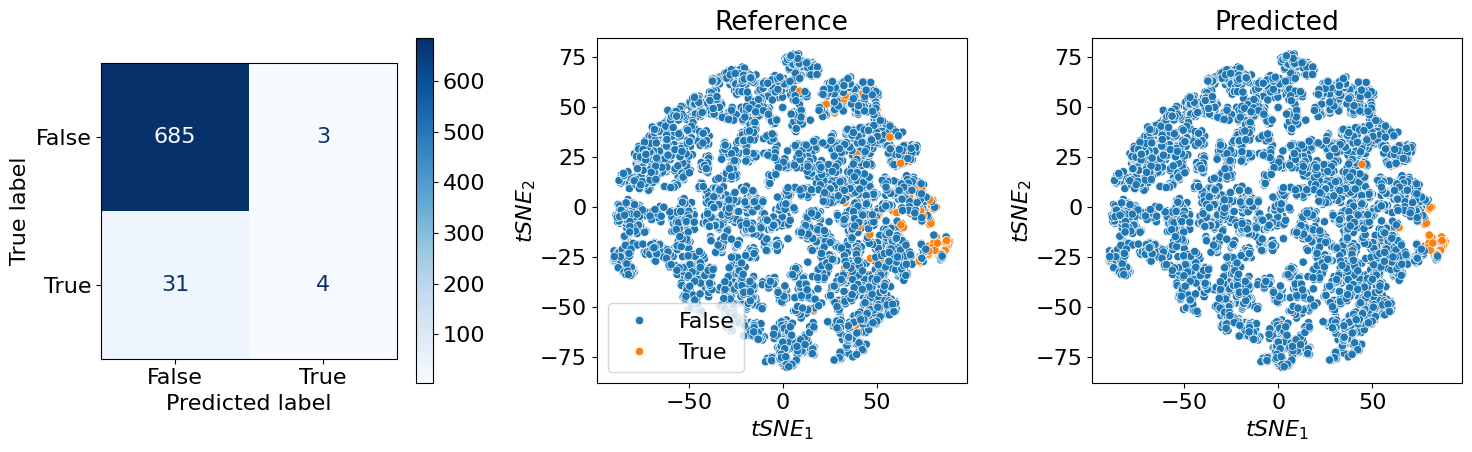

In [13]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'][dbresults['testidx']].argmax(axis=-1).tolist()
y_classes = dbresults['y_cls'][dbresults['testidx']].argmax(axis=-1)
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'][dbresults['testidx']], dbresults['pred_cls'][dbresults['testidx']])
print(mname,'binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy(),'AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.savefig(mname+'_tsne.png',format='png',dpi=800,bbox_inches = "tight")
plt.show()

/content/elementsem/models/elembert_toxic_sr-p53_V0_E_32_H_2_L_2 binary tf-acc: 0.96871376 AUC: 0.98945105
/content/elementsem/models/elembert_toxic_sr-p53_V1_E_32_H_2_L_2 binary tf-acc: 0.9571263  AUC: 0.9820951
/content/elementsem/models/elembert_toxic_sr-mmp_V0_E_32_H_2_L_2 binary tf-acc: 0.8920765 AUC: 0.9487883
/content/elementsem/models/elembert_toxic_sr-mmp_V1_E_32_H_2_L_2 binary tf-acc: 0.90163934 AUC: 0.94474494
/content/elementsem/models/elembert_toxic_sr-hse_V0_E_32_H_2_L_2 binary tf-acc: 0.94969326 AUC: 0.95752335
/content/elementsem/models/elembert_toxic_sr-hse_V1_E_32_H_2_L_2 binary tf-acc: 0.9190184 AUC: 0.9508389
/content/elementsem/models/elembert_toxic_sr-atad5_V0_E_32_H_2_L_2 binary tf-acc: 0.9570957 AUC: 0.9825725
/content/elementsem/models/elembert_toxic_sr-atad5_V1_E_32_H_2_L_2 binary tf-acc: 0.9537954 AUC: 0.9790919
/content/elementsem/models/elembert_toxic_sr-are_V0_E_32_H_2_L_2 binary tf-acc: 0.8563459 AUC: 0.90734774
/content/elementsem/models/elembert_toxic_sr-are_V1_E_32_H_2_L_2 binary tf-acc: 0.83682007 AUC: 0.9020403
/content/elementsem/models/elembert_toxic_nr-ppar-gamma_V0_E_32_H_2_L_2 binary tf-acc: 0.9767726 AUC: 0.9827267
/content/elementsem/models/elembert_toxic_nr-ppar-gamma_V1_E_32_H_2_L_2 binary tf-acc: 0.97310513 AUC: 0.98619694
/content/elementsem/models/elembert_toxic_nr-er_V0_E_32_H_2_L_2 binary tf-acc: 0.9103896 AUC: 0.92926294
/content/elementsem/models/elembert_toxic_nr-er_V1_E_32_H_2_L_2 binary tf-acc: 0.8922078 AUC: 0.9366631
/content/elementsem/models/elembert_toxic_nr-er-lbd_V0_E_32_H_2_L_2 binary tf-acc: 0.9565714 AUC: 0.97466516
/content/elementsem/models/elembert_toxic_nr-er-lbd_V1_E_32_H_2_L_2 binary tf-acc: 0.9497143 AUC: 0.97794485
/content/elementsem/models/elembert_toxic_nr-ar_V0_E_32_H_2_L_2 binary tf-acc: 0.9604701 AUC: 0.9732301
/content/elementsem/models/elembert_toxic_nr-ar_V1_E_32_H_2_L_2 binary tf-acc: 0.9583333 AUC: 0.96689063
/content/elementsem/models/elembert_toxic_nr-aromatase_V0_E_32_H_2_L_2 binary tf-acc: 0.9626556 AUC: 0.9822728
/content/elementsem/models/elembert_toxic_nr-aromatase_V1_E_32_H_2_L_2 binary tf-acc: 0.9585062 AUC: 0.9869759

/content/elementsem/models/elembert_toxic_nr-aromatase_V1_E_32_H_2_L_2 binary tf-acc: 0.9515906 AUC: 0.9795726